# Определение возраста покупателей

**Описание проекта:**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Задача проекта:**

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

**Инструкция по выполнению проекта:**

- *Проведите исследовательский анализ набора фотографий.*
- *Подготовьте данные к обучению.*
- *Обучите нейронную сеть и рассчитайте её качество.*

**Описание данных:**

Данные взяты с сайта ChaLearn Looking at People. Они находятся в папке `/datasets/faces/`.
В вашем распоряжении одна папка со всеми изображениями `(/final_files)` и CSV-файл `labels.csv` с двумя колонками: `file_name` и `real_age`.
Извлечь данные из папки вам поможет новый метод `ImageDataGenerator` `—flow_from_dataframe(dataframe, directory, ...)`.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.info()
labels.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


(7591, 2)

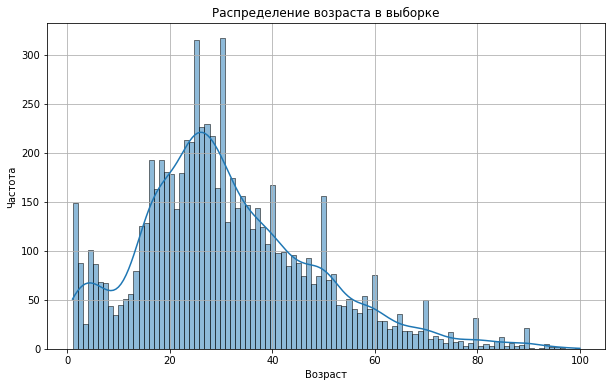

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(labels['real_age'], bins=100, kde=True)
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.grid()

plt.show()

In [5]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [6]:
datagen = ImageDataGenerator(validation_split=0.25, rescale=1.0/255)

train_datagen_flow = datagen.flow_from_dataframe(
       dataframe=labels,
       directory='/datasets/faces/final_files',
       x_col='file_name',
       y_col='real_age',
       target_size=(224, 224),  
       batch_size=32,
       class_mode='raw'  
   )

Found 7591 validated image filenames.


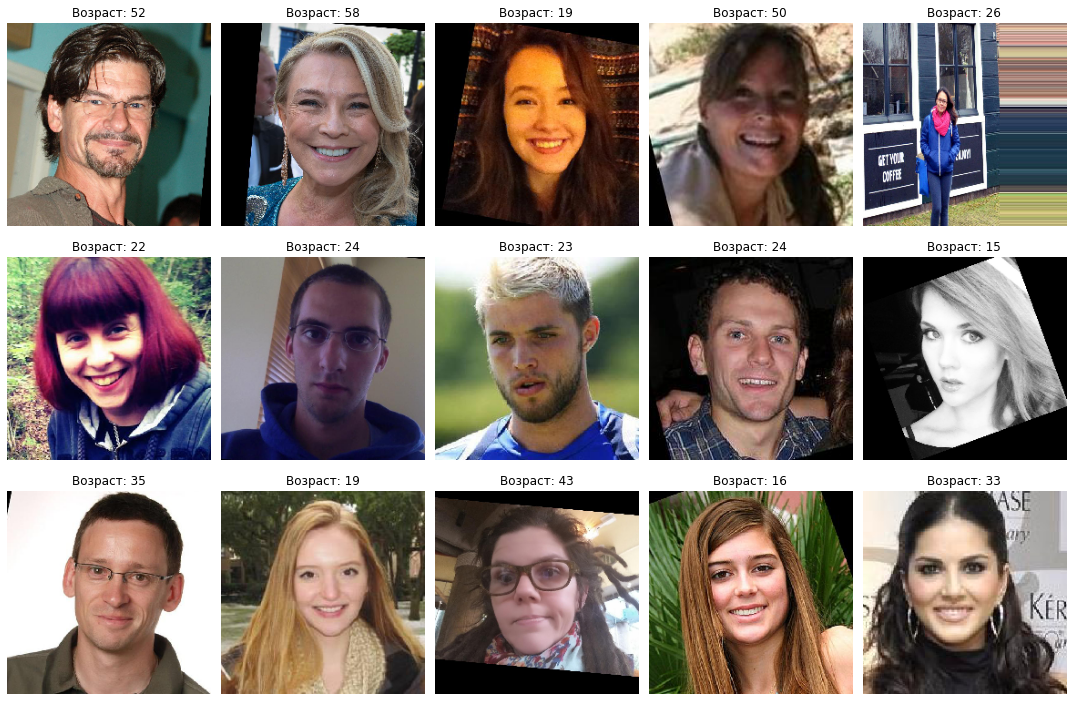

In [15]:
images, labels = next(train_datagen_flow)

sample_images = images[:15]
sample_labels = labels[:15]

plt.figure(figsize=(15, 10))
for i in range(15):
    plt.subplot(3, 5, i + 1)  
    plt.imshow(sample_images[i])  
    plt.axis('off')  
    plt.title(f'Возраст: {sample_labels[i]}')  
plt.tight_layout()
plt.show()

**Вывод** 

Проанализировав данные, получили 7591 фотографий с указанием возраста от 1 года до 100 лет, где средний возраст равен 31 году. Исходя из графика возраста, видим 2 пика. Первый дети от 1 до 6 лет. Второй 25-35 лет. Для получения лучших результатов в выборке именно для этих данных не хватает подросткового возраста или можно было бы уменьшить, или исключить детей до 7 лет. 

Плюс фотографий очень мало, плохого качества, разрешения(старые, обрезанные, разные ракурсы(в профиль, не видно лица), черно-белые, тусклые или засвеченные, размытые, с улыбками или без или с гримасой) с посторонними предметами(головные уборы, очки и др.). А также разной рассовой принадлежности, что затрудняет определить возраст(Допустим азиаты часто выглядят моложе своего возраста).

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from sklearn.metrics import mean_absolute_error


def load_train(path, seed):
    labels = pd.read_csv(path + '/labels.csv')
    
    datagen = ImageDataGenerator(
        validation_split=0.25, 
        rescale=1.0/255,
        horizontal_flip=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest'                    
    )
    
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224), 
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=seed
    )

    return train_datagen_flow

def load_test(path, seed):
    labels = pd.read_csv(path + '/labels.csv')
    
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1.0/255)
    
    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224), 
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=seed
    )

    return test_datagen_flow

def create_model(input_shape):
    model = Sequential()
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    #backbone.trainable = False
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.0001), metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=30, 
                steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

# path = '/datasets/faces/'
# seed = 12345
# input_shape = (224, 224, 3)
# train_data = load_train(path, seed)
# test_data = load_test(path, seed)
# model = create_model(input_shape)
# train_model(model, train_data, test_data)

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.
Train for 178 steps, validate for 60 steps
Epoch 1/30
178/178 - 117s - loss: 16.4097 - mae: 16.4104 - val_loss: 14.2871 - val_mae: 14.2626
Epoch 2/30
178/178 - 106s - loss: 12.7867 - mae: 12.7871 - val_loss: 13.0166 - val_mae: 12.9723
Epoch 3/30
178/178 - 107s - loss: 12.0271 - mae: 12.0266 - val_loss: 15.8330 - val_mae: 15.8139
Epoch 4/30
178/178 - 106s - loss: 11.5530 - mae: 11.5526 - val_loss: 12.3276 - val_mae: 12.2915
Epoch 5/30
178/178 - 111s - loss: 11.2788 - mae: 11.2781 - val_loss: 10.9025 - val_mae: 10.8892
Epoch 6/30
178/178 - 113s - loss: 11.0779 - mae: 11.0778 - val_loss: 8.4685 - val_mae: 8.4765
Epoch 7/30
178/178 - 113s - loss: 10.9134 - mae: 10.9134 - val_loss: 9.7411 - val_mae: 9.7506
Epoch 8/30
178/178 - 111s - loss: 9.5126 - mae: 9.5129 - val_loss: 7.9648 - val_mae: 7.9960
Epoch 19/30
178/178 - 111s - loss: 9.3512 - mae: 9.3509 - val_loss: 7.8386 - val_mae: 7.8503
Epoch 20/30
178/178 - 114s - loss: 9.3051 - mae: 9.3059 - val_loss: 8.5912 - val_mae: 8.5937
Epoch 21/30
178/178 - 117s - loss: 9.3999 - mae: 9.3997 - val_loss: 8.4843 - val_mae: 8.5276
Epoch 22/30
178/178 - 117s - loss: 9.0913 - mae: 9.0915 - val_loss: 13.8959 - val_mae: 13.9252
Epoch 23/30
178/178 - 116s - loss: 9.1586 - mae: 9.1593 - val_loss: 8.3782 - val_mae: 8.4245
Epoch 24/30
178/178 - 117s - loss: 9.2314 - mae: 9.2313 - val_loss: 7.3430 - val_mae: 7.3531
Epoch 25/30
178/178 - 111s - loss: 9.0301 - mae: 9.0299 - val_loss: 11.2675 - val_mae: 11.2618
Epoch 26/30
178/178 - 110s - loss: 8.8336 - mae: 8.8339 - val_loss: 8.9415 - val_mae: 8.9492
Epoch 27/30
178/178 - 113s - loss: 8.8259 - mae: 8.8261 - val_loss: 8.3030 - val_mae: 8.2837
Epoch 28/30
178/178 - 107s - loss: 9.0149 - mae: 9.0152 - val_loss: 7.5614 - val_mae: 7.6051
Epoch 29/30
178/178 - 115s - loss: 8.8369 - mae: 8.8372 - val_loss: 8.6080 - val_mae: 8.6279
Epoch 30/30
178/178 - 110s - loss: 8.8981 - mae: 8.8981 - val_loss: 7.6600 - val_mae: 7.6619
60/60 - 11s - loss: 7.6600 - mae: 7.6619

```

## Анализ обученной модели

**Общий вывод:**

Получили данные, провели исследовательский анализ набора фотографий, где 7591 фотографий с указанием возраста от 1 года до 100 лет. Построили график распределения возраста, где средний возраст составил 31 год. 
Напечатали на экране 15 фотографий и посмотрели. Фотографии плохого качества. 

Определили, что данных мало и плохого качества, поэтому не стоит ждать хороших результатов обучения модели.

<u>Подготовили данные:</u> 

Функции `load_train` и `load_test` загружают данные для обучения и тестирования соответственно.
Данные дополнены с помощью `ImageDataGenerator`, который включает такие методы, как переворот, вращение и смещение, чтобы повысить устойчивость модели к переобучению. Данные разделены на обучающую (75%) и валидационную (25%) выборки.
Функцией `create_model` создали модель с использованием `API Sequential` и самой известной архитектурой `ResNet50` в качестве основы.
Обучение использует среднюю абсолютную ошибку (MAE) в качестве функции потерь, что уместно для задач регрессии, таких как предсказание возраста.

<u>Результаты модели:</u>

На первых этапах обучения значения MAE были значительно высокими (например, 16.41 на первой эпохе),дальше наблюдается постепенное снижение MAE, достигнув 7.66 к 30-й эпохе. Это указывает на то, что модель успешно обучается и делает более точные предсказания по мере прохождения эпох.
MAE на валидационной выборке сначала также снижалось, что является хорошим признаком. Попеременное повышение и понижение MAE на валидации в некоторых эпохах (например, с 9.39 на 21-й по 8.38 на 23-й) может свидетельствовать о переобучении. Однако, окончательное значение MAE на валидации 7.66 свидетельствует о том, что модель, в целом, хорошо обобщается на тестовых данных.
Таким образом, свёрточная нейронная сеть показывает хорошие результаты, и есть возможность дальнейшего улучшения.

<u>Рекомендации:</u>
- Увеличить и улучшить набор данных (улучшить аугментацию)
- Лучше подобрать и настроить параметры модели (поменять архитектуру, добавив, заморозив слои и регуляризацию, поменять дропауты)
- Можно использовать несколько моделей, или другую более обученную модель